# Sentiment Analysis Colx 565
# Sentiment Classification and Text Detoxification Project

**Team Members:**

1. Muhammad Mujtaba Khan
2. Kartik Sirwani

**Citations:**

1. https://github.ubc.ca/MDS-CL-2024-25/COLX_565_sentiment_students/blob/master/tutorials/LLM-Prompting.ipynb
2. https://github.ubc.ca/MDS-CL-2024-25/COLX_565_sentiment_students/blob/master/tutorials/LangChainTutorial-Part-4-LoadingToolsChains.ipynb
3. https://www.marktechpost.com/2025/03/06/a-coding-guide-to-sentiment-analysis-of-customer-reviews-using-ibms-open-source-ai-model-granite-3b-and-hugging-face-transformers/
4. https://huggingface.co/mradermacher/DetoxLLM-7B-i1-GGUF
5. https://huggingface.co/UBC-NLP/toucan-base
6. https://github.ubc.ca/MDS-CL-2024-25/COLX_565_sentiment_students/blob/master/tutorials/LoadQuantizedDetoxLLM.ipynb
7. https://github.ubc.ca/MDS-CL-2024-25/COLX_565_sentiment_students/blob/master/tutorials/LangChainTutorial-Part-5-agents.ipynb

# Loading Libraries and Integrating Drive

## Libraries Installation

In [11]:
!pip install langchain_ollama langchain_community langchain
!pip install transformers langchain_openai langchain_huggingface
!pip install langid
!pip install llama-cpp-python
!pip install langgraph

## Integrate Drive folder

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
# folder_path = '/content/drive/My Drive/UBC_MDS/Colx_565_Sentiment'
folder_path = '/content/drive/My Drive/565_milestone_2'
files = os.listdir(folder_path)
print(files)

Mounted at /content/drive
['Milstone-2-multilingual-sentiment-test-solutions.csv', 'Milestone-2-toxic-test-solutions.csv', 'translated_sentiment_data.csv', 'DetoxLLM-7B.i1-Q6_K.gguf', 'DetoxLLM-7B.i1-Q3_K_S.gguf', 'Inferenced-Milestone-2-toxic-test-solutions.csv', 'Inferenced-Milstone-2-multilingual-sentiment-test-solutions.csv']


## Load Libraries

In [14]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, MT5ForConditionalGeneration
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import langid
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.schema.runnable import RunnableLambda
from typing import Literal, TypedDict
from langgraph.graph import StateGraph, END
from langgraph.types import Command, Send
from langchain_core.messages import HumanMessage
from langchain_community.llms import LlamaCpp
from llama_cpp import Llama
from IPython.display import display, Image
import re
from sklearn.metrics import cohen_kappa_score
import numpy as np
import krippendorff
from nltk.metrics.agreement import AnnotationTask

# Langraph Pipeline

## Models

### Language Detection Function

In [ ]:
def classify_language(sentence):
    lang, _ = langid.classify(sentence)
    if lang == 'en':
        return 'English'
    else:
        return 'African'

### Translation Model

In [ ]:
tokenizer_translate = AutoTokenizer.from_pretrained("UBC-NLP/toucan-base")
translate_model = MT5ForConditionalGeneration.from_pretrained("UBC-NLP/toucan-base", torch_dtype=torch.float16, device_map="auto")
translate_model.eval()

translate_pipeline = pipeline(
    task="text2text-generation",
    model=translate_model,
    tokenizer=tokenizer_translate,
    torch_dtype=torch.float16,
    max_new_tokens=50,
    temperature=0.6,
    do_sample=True,
    top_p = 0.9,
    num_beams=5
)

translate_llm = HuggingFacePipeline(pipeline=translate_pipeline)

def translate_language(input_text):

    return translate_llm.invoke("eng: "+ input_text)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.80M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-5-e7cd6d48e363>:17: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  translate_llm = HuggingFacePipeline(pipeline=translate_pipeline)


### Sentiment Model

In [ ]:
tokenizer_sentiment = AutoTokenizer.from_pretrained("ibm-granite/granite-3.0-2b-instruct")
sentiment_model = AutoModelForCausalLM.from_pretrained("ibm-granite/granite-3.0-2b-instruct", device_map="auto", torch_dtype=torch.float16)
sentiment_model.eval()


tokenizer_config.json:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GraniteForCausalLM(
  (model): GraniteModel(
    (embed_tokens): Embedding(49155, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x GraniteDecoderLayer(
        (self_attn): GraniteAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GraniteMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): GraniteRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): GraniteRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): GraniteRMSNorm((2048,)

In [ ]:
sentiment_pipeline = pipeline(
    task="text-generation",
    model=sentiment_model,
    tokenizer=tokenizer_sentiment,
    torch_dtype=torch.float16,
    max_new_tokens=250,
    temperature=0.6,
    top_p=0.9,
    do_sample=True,
    return_full_text=False
)

sentiment_llm = HuggingFacePipeline(pipeline=sentiment_pipeline)


def extract_sentiment_and_explanation(output):
    sentiment_match = re.search(r'"sentiment":\s*"([^"]+)"', output)
    explanation_match = re.search(r'"explanation":\s*"([^"]+)"', output)

    sentiment = sentiment_match.group(1).lower() if sentiment_match else None
    explanation = explanation_match.group(1) if explanation_match else "Failed to extract sentiment."

    return sentiment, explanation

def get_sentiment(input_text):
    sentiment_prompt = PromptTemplate(
        input_variables=["text"],
        template=(
            "You are an expert sentiment analysis assistant. "
            "Classify the given text as 'positive', 'negative', or 'mixed'. "
            "Provide your response in the following JSON format:\n\n"
            "{{\n" 
            '  "sentiment": "<positive/negative/mixed>",\n'
            '  "explanation": "<Brief explanation of sentiment>"\n'
            "}}\n\n"
            "Analyze the sentiment of the following sentence: {text}"
        )
    )
    sentiment_chain = sentiment_prompt | sentiment_llm | RunnableLambda(lambda x: x.strip())
    output = sentiment_chain.invoke({"text": input_text})

    return extract_sentiment_and_explanation(output)

Device set to use cuda:0


### Toxicity Detection and Detoxification Model

In [ ]:
#!huggingface-cli download mradermacher/DetoxLLM-7B-i1-GGUF DetoxLLM-7B.i1-IQ1_S.gguf --local-dir ./ --local-dir-use-symlinks False

In [ ]:
# Load the quantized model using LlamaCpp
# toxicity_llm = LlamaCpp(
#     model_path="./DetoxLLM-7B.i1-IQ1_S.gguf",
#     temperature=0.75,
#     max_tokens=50,
#     n_gpu_layers=-1,
#     verbose=False
# )

device = "cuda"
model_path = "UBC-NLP/DetoxLLM-7B"
tokenizer = AutoTokenizer.from_pretrained(model_path)
toxicity_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", torch_dtype=torch.float16)
toxicity_model.eval()


toxicity_pipeline = pipeline(
    task="text-generation",
    model=toxicity_model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    max_new_tokens=50,
    temperature=0.75,
    do_sample=True,
    return_full_text=False
)

toxicity_llm = HuggingFacePipeline(pipeline=toxicity_pipeline)

#toxicity_llm = Llama(model_path="./DetoxLLM-7B.i1-IQ3_XXS.gguf", n_gpu_layers=-1, verbose=False)

def parse_toxicity_output(output_text):
    result = {"toxicity_label": None, "explanation": None}
    lines = output_text.strip().split("\n")

    for line in lines:
        if "Toxicity Label" in line:
            label = line.split(":")[1].strip().lower()
            result["toxicity_label"] = label
        elif "Explanation:" in line:
            explanation = line.split("Explanation:", 1)[-1].strip()
            result["explanation"] = explanation

    return result


def get_toxicity(input_text):
    toxicity_prompt = PromptTemplate(
    input_variables=["text"],  # Ensure it takes input from LangChain
    template=(
        "You are an expert Toxicity Classifier. Classify the text as toxic or not-toxic and also provide explanation.\n"
        "Here are a few examples of your task:\n\n"

        "Sentence: \"You are completely clueless.\"\n"
        "Toxicity Label: toxic\n"
        "Explanation: Insulting language directed at the recipient.\n\n"

        "Sentence: \"go blow your bitch GabrielF =\"\n"
        "Toxicity Label: toxic\n"
        "Explanation: Offensive language like bitch used\n\n"

        "Sentence: \"Kill yourself! Fuckin' bastard!\"\n"
        "Toxicity Label: toxic\n"
        "Explanation: Offensive language and personal attack aimed at recipient's life.\n\n"

        "Sentence: \"No, you're being unwise.\"\n"
        "Toxicity Label: non-toxic\n"
        "Explanation: This input text is not toxic.\n\n"

        "Sentence: \"{text}\""
      )
    )
    toxicity_chain = toxicity_prompt | toxicity_llm | RunnableLambda(lambda x: parse_toxicity_output(x))
    output = toxicity_chain.invoke({"text": input_text})
    print(output)
    return output["toxicity_label"], output["explanation"]

def detoxify_text(input_text):
    detoxify_prompt = PromptTemplate(
        input_variables=["text"],
        template="Detoxify the following toxic sentence:\n{text}\nNon-toxic version:"
    )
    detoxify_chain = detoxify_prompt | toxicity_llm | RunnableLambda(lambda x: x.strip())
    return detoxify_chain.invoke({"text": input_text})


tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.68G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

Device set to use cuda:0


## LangGraph Workflow Pipeline

### Defining Nodes and State

In [ ]:
class State(TypedDict):
    input_text: str
    translated_text: str
    sentiment_label: str
    sentiment_explanation: str
    toxicity_label: str
    toxicity_explanation: str
    detoxified_text: str

# Defining Nodes

def language_detection_node(state: State) -> Command[Literal["translate", "sentiment"]]:
    language = classify_language(state["input_text"])
    if language == "English":

        return Command(
            goto="sentiment",
            update={"translated_text": state["input_text"]}  # Set translated_text to the input text
        )
    else:
        # If the text is not in English, go to the translation node
        return Command(
              goto="translate",
              update={"translated_text": state["input_text"]}
            )

def translate_node(state: State) -> Command[Literal["sentiment"]]:
    translated_text = translate_language(state["input_text"])
    return Command(
        goto="sentiment",
        update={"translated_text": translated_text}  # Update translated_text in the state
    )

def sentiment_node(state: State) -> Command[Literal["toxicity"]]:
    sentiment_label, sentiment_explanation = get_sentiment(state["translated_text"])
    return Command(
        goto="toxicity",
        update={
            "sentiment_label": sentiment_label,
            "sentiment_explanation": sentiment_explanation
        }
    )

def toxicity_node(state: State) -> Command[Literal["detoxify", "__end__"]]:
    toxicity_label, toxicity_explanation = get_toxicity(state["translated_text"])
    if toxicity_label == "toxic":
        return Command(
            goto="detoxify",
            update={
                "toxicity_label": toxicity_label,
                "toxicity_explanation": toxicity_explanation
                }
            )
    else:
        return Command(
            goto=END,
            update={
                "toxicity_label": toxicity_label,
                "toxicity_explanation": toxicity_explanation,
                "detoxified_text": None
            }
        )

def detoxify_node(state: State) -> Command[Literal["__end__"]]:
    detoxified_text = detoxify_text(state["translated_text"])
    return Command(
        goto=END,
        update={"detoxified_text": detoxified_text}
    )


### Building Edges of the Graph

In [ ]:
# Build the graph
builder = StateGraph(State)
builder.add_node("language_detection", language_detection_node)
builder.add_node("translate", translate_node)
builder.add_node("sentiment", sentiment_node)
builder.add_node("toxicity", toxicity_node)
builder.add_node("detoxify", detoxify_node)

builder.set_entry_point("language_detection")
builder.add_edge("language_detection", "sentiment")
builder.add_edge("translate", "sentiment")
builder.add_edge("sentiment", "toxicity")
builder.add_edge("toxicity", END)
builder.add_edge("detoxify", END)

graph = builder.compile()

### Defining the Run Workflow


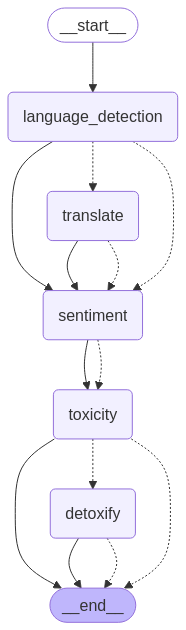

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def run_workflow(input_text):
    initial_state = {"input_text": input_text}
    final_state = graph.invoke(initial_state)
    return {
        "sentiment_label": final_state["sentiment_label"],
        "sentiment_explanation": final_state["sentiment_explanation"],
        "toxicity_label": final_state["toxicity_label"],
        "toxicity_explanation": final_state["toxicity_explanation"],
        "detoxified_text": final_state["detoxified_text"]
    }

### Examples

In [ ]:
# Example Usage 1
input_text = "This is very bad and terrible product unfortunately I will never step my foot in this place again"
result = run_workflow(input_text)
print("Output: \n", result)

{'toxicity_label': 'toxic', 'explanation': 'The input text contains offensive language and a personal attack towards the product and the place.'}
Output: 
 {'sentiment_label': 'negative', 'sentiment_explanation': 'The sentiment is negative as the user expresses dissatisfaction with the product and states they will never return to the place.', 'toxicity_label': 'toxic', 'toxicity_explanation': 'The input text contains offensive language and a personal attack towards the product and the place.', 'detoxified_text': "This is a disappointing and unfortunate product. I won't be returning to this place again."}


In [ ]:
# Example Usage 2
input_text = "Loved this restaurant, delicious menu and amazing service by the staff"
result = run_workflow(input_text)
print("Output: \n", result)

{'toxicity_label': 'non-toxic', 'explanation': 'A positive and appreciative statement about a restaurant, without any form of toxicity.'}
Output: 
 {'sentiment_label': 'positive', 'sentiment_explanation': 'The user expresses a positive sentiment towards the restaurant, mentioning enjoyment, a delicious menu, and excellent service.', 'toxicity_label': 'non-toxic', 'toxicity_explanation': 'A positive and appreciative statement about a restaurant, without any form of toxicity.', 'detoxified_text': None}


In [ ]:
# Example Usage 3
input_text = "Nashukuru huduma ya haraka, lakini chakula kimefika kikiwa baridi, si tamu kamwe."
result = run_workflow(input_text)
print("Output: \n", result)

{'toxicity_label': 'non-toxic', 'explanation': 'This input text is not toxic. It expresses a dissatisfaction with the service and food, but it does not contain offensive language, hate speech, or personal'}
{'toxicity_label': 'non-toxic', 'explanation': 'This input text is not toxic. It expresses a dissatisfaction with the service and the food quality, but it does not contain offensive language, hate speech,'}
Output: 
 {'sentiment_label': 'negative', 'sentiment_explanation': 'The user expresses dissatisfaction with the cold food and the lack of sweetness, which indicates a negative sentiment.', 'toxicity_label': 'non-toxic', 'toxicity_explanation': 'This input text is not toxic. It expresses a dissatisfaction with the service and the food quality, but it does not contain offensive language, hate speech,', 'detoxified_text': None}


# Inferencing Pipeline

## Loading Datasets

In [ ]:

sentiment_csv_path = os.path.join(folder_path, "Milstone-2-multilingual-sentiment-test-solutions.csv")
sentiment_df = pd.read_csv(sentiment_csv_path)

sentiment_df

,sentence id,sentence,class-label
0,1,Ni kipaji gani! Hiki kipikiosafi kinafanya kaz...,mixed
1,2,"Ninapenda ubora wa picha, ila simu hii inajifu...",mixed
2,3,"Kweli, kozi hii ya mtandaoni inavutia, lakini ...",negative
3,4,"Nashukuru huduma ya haraka, lakini chakula kim...",negative
4,5,"Haya magari mapya ni mazuri, ila bei yake 'ina...",mixed
...,...,...,...
95,96,You’re doing a great job with that tutorial se...,positive
96,97,"This mattress is comfy as heck, but the chemic...",mixed
97,98,I’d say your language-learning app is a must-h...,mixed
98,99,"I guess I appreciate the free upgrade, though ...",mixed


In [ ]:
toxic_csv_path = os.path.join(folder_path, "Milestone-2-toxic-test-solutions.csv")


toxic_df = pd.read_csv(toxic_csv_path)

toxic_df

,data_id,sample_id,text,source_label,platform
0,111252,0,I know he's an idiot I think he might of been ...,toxic,wikipedia
1,152758,1,==my butthole== i love buttholes. they tast...,toxic,wikipedia
2,126091,2,This is absolute bullshit! We fucking knew thi...,non-toxic,fox news
3,28115,3,Moochelle Nobama takes swipe at Trump it sez. ...,toxic,fox news
4,2997,4,"2. \t> Lol, I guessed IPN (the Institue of Nat...",toxic,reddit
...,...,...,...,...,...
95,66535,95,She doesn't honor President Trump. She doesn't...,toxic,fb_yt
96,18630,96,You're just a clueless hypocrite if you really...,non-toxic,fox news
97,31642,97,2. \tI hope she runs She is a retard and most ...,toxic,gab
98,99771,98,Texas Voters Tell Us What They Think Of Donald...,toxic,fb_yt


## Running Inferences

In [ ]:
def run_workflow_on_dataframe(df, sentence_column, output_csv_path, batch_size=10):
    """
    Perform inference on a DataFrame and save results to a CSV file.

    Args:
        df (pd.DataFrame): Input DataFrame containing the sentences.
        sentence_column (str): Name of the column containing the sentences.
        output_csv_path (str): Path to the output CSV file.
        batch_size (int): Number of rows to process before saving progress.
    """
    # Define the new columns to be added
    new_columns = [
        "pred_sentiment_label",
        "sentiment_explanation",
        "pred_toxicity_label",
        "toxicity_explanation",
        "detoxified_text"
    ]

    if os.path.exists(output_csv_path):
        result_df = pd.read_csv(output_csv_path)

        # Find the first row where ALL new columns are NaN (fully unprocessed)
        unprocessed_rows = result_df[new_columns].isna().all(axis=1)

        if unprocessed_rows.any():
            start_index = unprocessed_rows.idxmax()  # First completely empty row
        else:
            start_index = len(result_df)  # Everything is already processed

        print(f"Resuming from index: {start_index}")

    else:
        result_df = df.copy()
        for col in new_columns:
            result_df[col] = None  # Initialize columns
        start_index = 0
        print("Starting fresh from index: 0")

    # Iterate over the DataFrame starting from the last processed row
    for i in range(start_index, len(df)):
        sentence = df.loc[i, sentence_column]

        # Perform inference using the LangGraph workflow
        try:
            result = run_workflow(sentence)
            result_df.at[i, "pred_sentiment_label"] = result["sentiment_label"]
            result_df.at[i, "sentiment_explanation"] = result["sentiment_explanation"]
            result_df.at[i, "pred_toxicity_label"] = result["toxicity_label"]
            result_df.at[i, "toxicity_explanation"] = result["toxicity_explanation"]
            result_df.at[i, "detoxified_text"] = result["detoxified_text"]
        except Exception as e:
            print(f"Error processing row {i}: {e}")
            continue
        # result = run_workflow(sentence)



        # Save progress after every batch_size rows
        if (i + 1) % batch_size == 0:
            result_df.to_csv(output_csv_path, index=False)
            print(f"Processed {i + 1} rows. Progress saved to {output_csv_path}")


    # Save the final results
    result_df.to_csv(output_csv_path, index=False)
    print(f"Inference completed. Results saved to {output_csv_path}")
    return result_df

### Inference on Sentiment Data

In [ ]:
output_csv_path = os.path.join(folder_path, "Inferenced-Milstone-2-multilingual-sentiment-test-solutions.csv")   # Path to the output CSV file
sentence_column = "sentence"

# Run the workflow on the DataFrame
infer_sentiment_df = run_workflow_on_dataframe(sentiment_df, sentence_column, output_csv_path, batch_size=10)

Resuming from index: 100
Inference completed. Results saved to /content/drive/My Drive/565_milestone_2/Inferenced-Milstone-2-multilingual-sentiment-test-solutions.csv


### Inference on Toxicity Data

In [ ]:
output_csv_path = os.path.join(folder_path, "Inferenced-Milestone-2-toxic-test-solutions.csv")
sentence_column = "text"

# Run the workflow on the DataFrame
infer_toxic_df = run_workflow_on_dataframe(toxic_df, sentence_column, output_csv_path, batch_size=10)

Resuming from index: 80
{'toxicity_label': 'toxic', 'explanation': 'This input text contains hate speech targeted towards Affirmative Action, suggesting that it is racist and arguing that only the best person should move ahead. It also implies that Aff'}
{'toxicity_label': 'non-', 'explanation': 'Offensive language and personal attack aimed at the southern heritage.'}
{'toxicity_label': 'toxic', 'explanation': 'The input text is toxic as it contains offensive language, personal attacks, and curse words. The use of derogatory terms like "stupid idiot" and'}
{'toxicity_label': None, 'explanation': None}
{'toxicity_label': 'toxic', 'explanation': 'This input text is toxic because it contains offensive language.'}
{'toxicity_label': 'toxic', 'explanation': 'The input text contains offensive language and a personal attack. The use of the word "damn" and the phrase "you\'re being unwise" suggest a disrespect'}
{'toxicity_label': 'toxic', 'explanation': 'The input text is toxic because it con

### Loading inferenced data

In [4]:
sentiment_infer_path = "Inferenced-Milstone-2-multilingual-sentiment-test-solutions.csv"
toxic_infer_path = "Inferenced-Milestone-2-toxic-test-solutions.csv"
infer_sentiment_df = pd.read_csv(sentiment_infer_path)
infer_toxic_df = pd.read_csv(toxic_infer_path)

In [5]:
infer_sentiment_df['pred_sentiment_label'].value_counts()

,count
pred_sentiment_label,
negative,45
mixed,36
positive,19


In [6]:
infer_toxic_df['pred_toxicity_label'].value_counts()

,count
pred_toxicity_label,
toxic,71
non-toxic,5
non-to,3
non,2
non-,1


We observe that the predicted toxic labels are not clean for non-toxic, so we will clean it

In [7]:
def clean_toxic_label(label):
  if label == 'toxic':
    return 'toxic'
  else:
    return 'non-toxic'

infer_toxic_df['pred_toxicity_label'] = infer_toxic_df['pred_toxicity_label'].apply(lambda x: clean_toxic_label(x))

In [8]:
infer_toxic_df['pred_toxicity_label'].value_counts()

,count
pred_toxicity_label,
toxic,71
non-toxic,29


In [20]:
infer_toxic_df.to_csv("Inferenced-Milestone-2-toxic-test-solutions.csv")

Preparing detoxified files for Annotators

In [ ]:
detoxified_df_1 = infer_toxic_df[(infer_toxic_df['pred_toxicity_label']=='toxic') & (infer_toxic_df['source_label']=='toxic')].head(15)
detoxified_df_1 = detoxified_df_1[['data_id', 'text','detoxified_text']]

detoxified_df_2 = detoxified_df_1.copy(deep=True)

detoxified_df_1['Annotator_Muhammad'] = ""
detoxified_df_2['Annotator_Kartik'] = ""

detoxified_df_1.to_csv('Muhammad_detoxified_dataset.csv', index=False)
detoxified_df_2.to_csv('Kartik_detoxified_dataset.csv', index=False)

## Metrics Calculation

In [9]:
def calculate_metrics(true_labels, predicted_labels):
  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average='weighted')
  recall = recall_score(true_labels, predicted_labels, average='weighted')
  f1 = f1_score(true_labels, predicted_labels, average='weighted')

  print("\nMetrics:")
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

### Sentiment Classification Metrics

In [10]:
calculate_metrics(infer_sentiment_df['class-label'], infer_sentiment_df['pred_sentiment_label'])


Metrics:
Accuracy: 0.69
Precision: 0.7309356725146199
Recall: 0.69
F1 Score: 0.6865800865800865


### Toxicity Labelling Metrics

In [11]:
calculate_metrics(infer_toxic_df['source_label'], infer_toxic_df['pred_toxicity_label'])


Metrics:
Accuracy: 0.61
Precision: 0.5956289460903351
Recall: 0.61
F1 Score: 0.5952870892797876


## Detoxification evaluation

In [13]:
detoxified_df_1 = pd.read_csv('Muhammad_detoxified_dataset.csv')
detoxified_df_2 = pd.read_csv('Kartik_detoxified_dataset.csv')

Joining two annotator scores

In [19]:
merged_detox_df = detoxified_df_1.merge(
    detoxified_df_2[['data_id', 'Annotator_Kartik']],
    on="data_id",
    how="left"
)

merged_detox_df["Average_Score"] = (merged_detox_df["Annotator_Muhammad"]+ merged_detox_df["Annotator_Kartik"])/2
merged_detox_df.head(3)

merged_detox_df.to_csv("Annotated_detoxified_scores.csv")

### Compute Average Score across all examples

In [3]:
avg_score = merged_detox_df['Average_Score'].mean()

print(f"Average Score of detoxification across all samples: {avg_score:.3f}")

Average Score of detoxification across all samples: 7.067


### Compute Cohen's Kappa

In [18]:
kappa = cohen_kappa_score(merged_detox_df["Annotator_Muhammad"], merged_detox_df["Annotator_Kartik"])

print(f"Cohen's Kappa Score: {kappa:.3f}")

Cohen's Kappa Score: 0.246


### Compute Krippendorff's Alpha

In [16]:
def interval_distance(x, y):
    return (x - y) ** 2

triples = []
for idx, row in merged_detox_df.iterrows():
    triples.append(("Muhammad", idx, row["Annotator_Muhammad"]))
    triples.append(("Kartik", idx, row["Annotator_Kartik"]))

agreement_task = AnnotationTask(triples, distance=interval_distance)
alpha_score = agreement_task.alpha()

print(f"Krippendorff's Alpha: {alpha_score:.3f}")

Krippendorff's Alpha: 0.721
